In [13]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jan 27 09:40:41 2021

@author: Johanna

pointnet from https://github.com/myx666/pointnet-in-pytorch/blob/master/pointnet.pytorch/dataset.py
"""


import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

import sys 
sys.path.insert(0, './Onedrive/Project-T2/PointNetJJ')
from spheres_JJ import sphere_generator
from spheres_JJ import ellipsoid_gen_axis_change

from rotation import rotate_point_cloud
from rotation import LOP

   
nclouds = 10000
npoints = 100

# Labels are uniform(ish) in (1,9)
labels = ((torch.rand(nclouds) * 7)).view(-1,1)

# The point clouds

ellipsoids = torch.from_numpy(ellipsoid_gen_axis_change(0.0,1 , 1 ,labels, nclouds, npoints))
trainset = ellipsoids

dataset = TensorDataset(trainset, labels)
# Creating the batches
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32,
                                          shuffle=True, num_workers=2)

#####################################################
# Testing

ncloudstest = 10000
npointstest = 100

# Labels are uniform(ish) in (1,9)
testlabels = ((torch.rand(ncloudstest) * 6.5)+0.5).view(-1,1)

# The point clouds
testset = torch.from_numpy(ellipsoid_gen_axis_change(0.0,1 , 1 ,testlabels, ncloudstest, npointstest))
test = testset


labels_test = testlabels

testset = TensorDataset(testset, testlabels)
# Creating the batches
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                          shuffle=True, num_workers=2)

#############################################################3



torch.Size([10000, 1])


In [7]:
class PointNetCls(nn.Module):
    def __init__(self, k=16):
        super(PointNetCls, self).__init__()
        self.conv1 = torch.nn.Conv1d(npoints, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)
        self.bn6 = nn.BatchNorm1d(k)

        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        if self.training:
            x = F.relu(self.bn6(self.dropout(x) * 0.7))
            #x = self.bn6(self.dropout(x) * 0.7)
        else:
            x = F.relu(self.bn6(x))
            #x = self.bn6(x)
        return x

In [8]:
net = PointNetCls(k=1)


criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

nepochs = 50
for epoch in range(nepochs):  # loop over the dataset multiple times
    epoch_train_acc = 0.0
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(rotate_point_cloud(inputs))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 12.176
[1,   200] loss: 10.431
[1,   300] loss: 10.761
[2,   100] loss: 10.105
[2,   200] loss: 8.878
[2,   300] loss: 9.144
[3,   100] loss: 8.248
[3,   200] loss: 7.673
[3,   300] loss: 7.767
[4,   100] loss: 7.337
[4,   200] loss: 7.098
[4,   300] loss: 6.403
[5,   100] loss: 6.177
[5,   200] loss: 6.316
[5,   300] loss: 6.188
[6,   100] loss: 6.205
[6,   200] loss: 5.768
[6,   300] loss: 5.580
[7,   100] loss: 5.519
[7,   200] loss: 5.849
[7,   300] loss: 5.325
[8,   100] loss: 5.266
[8,   200] loss: 5.343
[8,   300] loss: 5.525
[9,   100] loss: 5.109
[9,   200] loss: 5.307
[9,   300] loss: 5.003
[10,   100] loss: 5.833
[10,   200] loss: 5.042
[10,   300] loss: 5.137
[11,   100] loss: 4.971
[11,   200] loss: 4.906
[11,   300] loss: 5.137
[12,   100] loss: 4.965
[12,   200] loss: 5.059
[12,   300] loss: 5.401
[13,   100] loss: 5.095
[13,   200] loss: 5.172
[13,   300] loss: 5.048
[14,   100] loss: 4.728
[14,   200] loss: 4.856
[14,   300] loss: 5.281
[15,   100] los

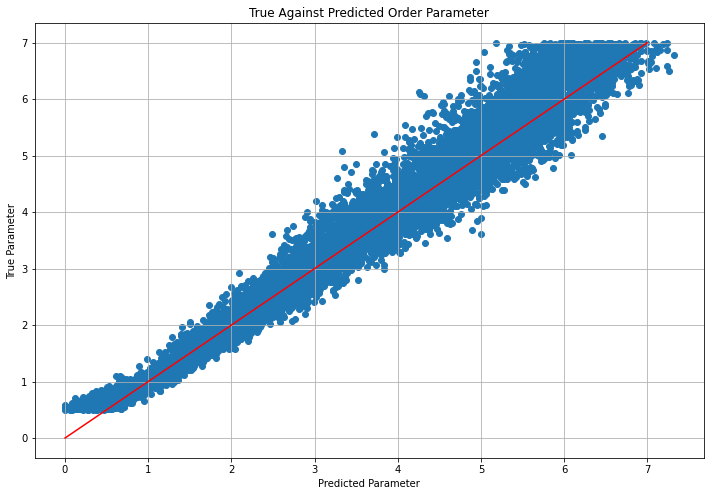

In [10]:
net.eval()
#net.train()
outputs = net(test)
x = outputs.detach().numpy()
y = labels_test

# plot the data
plt.figure(figsize=(12,8))
plt.scatter(x,y)
plt.plot(np.linspace(0, 7, 10), np.power(np.linspace(0, 7, 10), 1), color = 'r', label = 'y = x')
plt.grid()
#plt.xlim([0,1])
#plt.ylim([0,1])
plt.title("True Against Predicted Order Parameter")
plt.ylabel("True Parameter")
plt.xlabel("Predicted Parameter")
plt.show()

torch.Size([16, 1])
